In [1]:
import json
import numpy as np

# Open the file and read lines
with open('output.json', 'r') as file:
    drugs_data = json.load(file)

In [2]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        return json.JSONEncoder.default(self, obj)

def save_data(filename, data):
    with open(filename, 'w') as file:
        file.write('[\n')  # Write the opening bracket of the JSON list
        for i, entry in enumerate(data):
            # Write each dictionary as a JSON string followed by a comma and newline, except for the last entry
            if i < len(data) - 1:
                file.write(json.dumps(entry, cls=NumpyEncoder) + ',\n')
            else:
                # The last entry should not have a comma at the end
                file.write(json.dumps(entry, cls=NumpyEncoder) + '\n')
        file.write(']')  # Write the closing bracket of the JSON list

In [3]:
import json
# Assuming the JSON data is a list of dictionaries
# We will use a dictionary to remove duplicates based on a unique key in the dictionaries
unique_data = {each_dict['name']: each_dict for each_dict in drugs_data}.values()
for idx, drug in enumerate(unique_data):
    drug['id'] = idx

In [4]:
save_data('output2.json', unique_data)

In [5]:
import re
from nltk.corpus import stopwords

# Download NLTK stopwords if you haven't already
import nltk
nltk.download('stopwords')

# Define a list of custom stop words (add more if needed)
custom_stopwords = ["and", "the", "in", "with"]

def preprocess_text(text):
    # Remove text in parentheses
    
    text_no_parentheses = re.sub(r'\s*\([^)]*\)', '', text)
    
    # Remove commas
    text_no_commas = text_no_parentheses.replace(',', '')
    
    # Tokenize the text
    words = text_no_commas.split()
    
    # Remove stop words and custom stop words
    cleaned_words = [word for word in words if word.lower() not in set(custom_stopwords)]
    
    # Join the cleaned words back into a string
    cleaned_text = ' '.join(cleaned_words)
    if cleaned_text == '':
        print(f'{text} was converted to {cleaned_text}')
    # Return the cleaned text
    return cleaned_text


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidchun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
with open('output2.json', 'r') as file:
    drugs_data = json.load(file)

In [7]:
# Apply preprocessing to drug names
combined_features = [str((preprocess_text(drug['name']), drug['drug_classes'])) for drug in drugs_data]
# Display the processed names
#combined_features.sort()
len(combined_features)


11743

In [ ]:
combined_features = [re.sub(r"[()',\[\]]", "", entry) for entry in combined_features]
combined_features

In [ ]:
def find_drug_id_by_name(drug_name, drugs_data):
    for drug in drugs_data:
        if drug['name'] == drug_name:
            return drug['id']
    print('not found')
    return None  # or raise an exception, or any other way you prefer to handle not found cases

find_drug_id_by_name('', drugs_data)

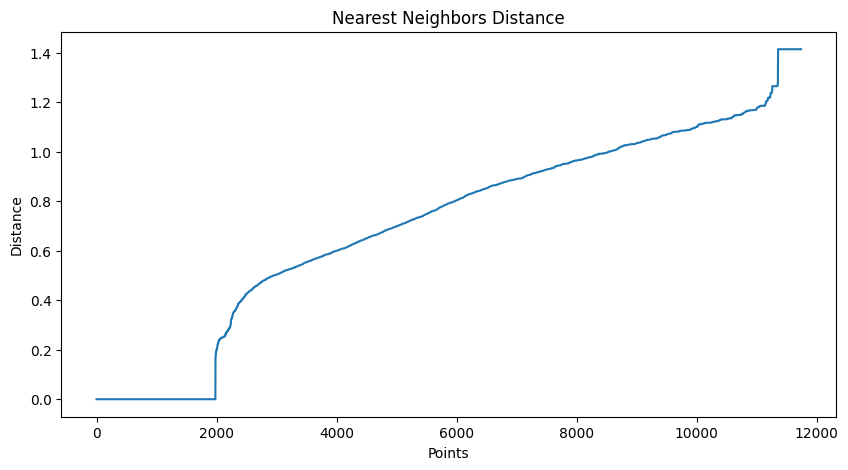

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Vectorize the Names
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(combined_features)

# Step 2: Find an Appropriate 'eps' Value
nearest_neighbors = NearestNeighbors(n_neighbors=2)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

# Sort the distances
sorted_distances = np.sort(distances, axis=0)
sorted_distances = sorted_distances[:, 1]

plt.figure(figsize=(10,5))
plt.plot(sorted_distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.title("Nearest Neighbors Distance")
plt.show()




In [9]:
# You will need to visually identify a suitable 'eps' value from this plot

# Step 3: Apply DBSCAN Clustering
# Assuming you chose an 'eps' value, for example, 0.3
eps_value = .55 # adjust based on your observations
dbscan = DBSCAN(eps=eps_value, min_samples=2)  # adjust min_samples as needed
clusters = dbscan.fit_predict(X)

# Output the cluster assignments
for name, cluster in zip(combined_features, clusters):
    print(f"Name: {name}, Cluster: {cluster}")

Name: ('Azulfidine', ['5-aminosalicylates', 'Antirheumatics']), Cluster: -1
Name: ('Abstral', ['Opioids (narcotic analgesics)']), Cluster: -1
Name: ('Aczone', ['Topical acne agents']), Cluster: -1
Name: ('Adzynma', []), Cluster: -1
Name: ('Adzenys XR-ODT', ['CNS stimulants']), Cluster: -1
Name: ('AfterPill', ['Contraceptives']), Cluster: -1
Name: ('Aftate', ['Topical antifungals']), Cluster: -1
Name: ('Afstyla', ['Miscellaneous coagulation modifiers']), Cluster: 0
Name: ('Airsupra', ['Antiasthmatic combinations']), Cluster: 1
Name: ('Airsupra', ['Antiasthmatic combinations']), Cluster: 1
Name: ('Akynzeo for', ['Miscellaneous antiemetics']), Cluster: 2
Name: ('Alyq', ['Agents for pulmonary hypertension']), Cluster: -1
Name: ('Amzeeq', []), Cluster: -1
Name: ('Anzemet', ['5HT3 receptor antagonists']), Cluster: 3
Name: ('Anzemet', ['5HT3 receptor antagonists']), Cluster: 3
Name: ('Aptivus', ['Protease inhibitors']), Cluster: -1
Name: ('Aquoral', ['Mouth and throat products']), Cluster: -1

In [10]:
clusters_dict = {}
for name, cluster in zip(combined_features, clusters):
    if cluster not in clusters_dict:
        clusters_dict[cluster] = []
    clusters_dict[cluster].append(name)

# Now you can print the drugs for each cluster or work with them as needed
for cluster, names in clusters_dict.items():
    print(f"Cluster {cluster}: {', '.join(names)}")

Cluster -1: ('Azulfidine', ['5-aminosalicylates', 'Antirheumatics']), ('Abstral', ['Opioids (narcotic analgesics)']), ('Aczone', ['Topical acne agents']), ('Adzynma', []), ('Adzenys XR-ODT', ['CNS stimulants']), ('AfterPill', ['Contraceptives']), ('Aftate', ['Topical antifungals']), ('Alyq', ['Agents for pulmonary hypertension']), ('Amzeeq', []), ('Aptivus', ['Protease inhibitors']), ('Aquoral', ['Mouth and throat products']), ('Aquazide H', ['Thiazide diuretics']), ('Aquatensen', ['Thiazide diuretics']), ('Aquaphor Healing', ['Topical emollients']), ('Aquaphilic Urea', ['Topical emollients']), ('Aquanil HC', ['Topical steroids']), ('Aquamephyton', ['Anticoagulant reversal agents', 'Vitamins']), ('Aquafresh', ['Mouth and throat products']), ('Aqua-Ban', ['Miscellaneous diuretics']), ('Aqua Gem-E', ['Vitamins']), ('Aqua Care', ['Topical emollients']), ('Aptensio XR', ['CNS stimulants']), ('Aprodine', ['Upper respiratory combinations']), ('Apricot', []), ('Apri', ['Contraceptives']), ('A

In [11]:
name_mapping = {entry['name']: name for entry, name in zip(drugs_data, combined_features)}
# Add normalized names and cluster assignments to your data
for entry, cluster in zip(drugs_data, clusters):
    entry['Cluster'] = cluster



In [12]:
save_data('o3.json', drugs_data)

In [13]:
from collections import defaultdict
import json
import numpy as np

def consolidate_clusters(drugs_data):
    # Group Data by Cluster, excluding -1
    cluster_groups = defaultdict(list)
    for drug in drugs_data:
        if drug['Cluster'] != -1:
            cluster_groups[drug['Cluster']].append(drug)
    
    # Consolidate Grouped Data
    consolidated_data = []
    for cluster, drugs in cluster_groups.items():
        if drugs:
            # Use the first drug's data as the template
            consolidated_entry = drugs[0].copy()
            # Replace name with the most common name in the cluster
            names = [drug['name'] for drug in drugs]
            consolidated_entry['name'] = min(set(names), key=names.count)
            # Optionally, combine other attributes here
            consolidated_entry['uses'] = list(set(use for drug in drugs for use in drug.get('uses', [])))
            consolidated_entry['drug_classes'] = list(set(use for drug in drugs for use in drug.get('drug_classes', [])))
            
            consolidated_data.append(consolidated_entry)
    
    # Include the entries with Cluster -1 as they are
    consolidated_data.extend(drug for drug in drugs_data if drug['Cluster'] == -1)
    
    return consolidated_data




In [14]:
# Assuming `drugs_data` is your list of dictionaries with 'Cluster' and 'Drug Name' keys
consolidated_drugs_data = consolidate_clusters(drugs_data)
cleaned_drug_data = [drug for drug in consolidated_drugs_data if len(drug['uses'] > 0)]
# Define a JSON encoder subclass to convert numpy integers to Python integers
save_data('consolidated_data.json', consolidated_drugs_data)

In [19]:
cleaned_drug_data = [drug for drug in consolidated_drugs_data if len(drug['uses']) > 0]
for drug in cleaned_drug_data:
    drug['name'] = re.sub(r"\s*\(.*?\)", "", drug['name'])


In [20]:
save_data('consolidated_data.json', cleaned_drug_data)

In [3]:
import spacy
import scispacy 

# Load the scispaCy model
nlp = spacy.load("en_core_sci_sm")

# Process a sample text
text = "Androgel Testosterone testosterone testosterone alcohol isopropyl myristate water sodium hydroxide CARBOMER HOMOPOLYMER TYPE C (ALLYL PENTAERYTHRITOL CROSSLINKED)"
doc = nlp(text)

# Extract entities recognized as DRUG
drugs = [ent for ent in doc.ents if ent.label_ == "DRUG"]
for drug in drugs:
    print(drug.text)




ModuleNotFoundError: No module named 'spacy'

In [19]:
!pip list

Package            Version
------------------ -------
altgraph           0.17.2
appnope            0.1.3
asttokens          2.4.1
comm               0.2.0
debugpy            1.8.0
decorator          5.1.1
exceptiongroup     1.2.0
executing          2.0.1
future             0.18.2
importlib-metadata 6.8.0
ipykernel          6.27.1
ipython            8.18.1
jedi               0.19.1
jupyter_client     8.6.0
jupyter_core       5.5.0
macholib           1.15.2
matplotlib-inline  0.1.6
nest-asyncio       1.5.8
packaging          23.2
parso              0.8.3
pexpect            4.9.0
pip                23.3.1
platformdirs       4.0.0
prompt-toolkit     3.0.41
psutil             5.9.6
ptyprocess         0.7.0
pure-eval          0.2.2
Pygments           2.17.2
python-dateutil    2.8.2
pyzmq              25.1.1
setuptools         58.0.4
six                1.15.0
stack-data         0.6.3
tornado            6.4
traitlets          5.14.0
typing_extensions  4.8.0
wcwidth            0.2.12
wheel     

In [17]:
!/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [18]:
import sys
print(sys.executable)


/Library/Developer/CommandLineTools/usr/bin/python3


In [11]:
!source ~/.zshrc  # for Zsh

In [9]:
!echo 'alias python=python3' >> ~/.zshrc
!source ~/.zshrc
